In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

In [2]:
class Camada():
    def __init__(self, profundidade: float, velocidade: float, densidade: float):
        self.prof = profundidade
        self.vel = velocidade
        self.rho = densidade
        self.imped = velocidade*densidade # impedância
        self.tempo = profundidade/velocidade

In [3]:
class Modelo():
    def __init__(self, camadas: List[Camada]):
        self.camadas = list(camadas)
        r = []
        t = []
        for i in range(len(camadas)-1):
            z1 = camadas[i].imped
            z2 = camadas[i+1].imped
            r_i = (z2 - z1) / (z2 + z1)
            t_i = 1 - r_i
            r.append(r_i)
            t.append(t_i)
        self.reflex = r
    def obter_pulsos(self, t_max: int = 3) -> pd.DataFrame:
        p = self.pulsar(i = 0, t = 0., pulso=1., sentido=1, t_max = t_max)
        return pd.DataFrame(p).groupby('instante').sum()
    def obter_pulsos_limpo(self, t_max: int = 3) -> pd.DataFrame:
        p = self.pulsar_limpo(i = 0, t = 0., pulso=1., sentido=1, t_max = t_max)
        return pd.DataFrame(p).groupby('instante').sum()
    def pulsar(self, i: int, t: float, pulso: float, sentido: int, t_max: int):
        t_i = t + self.camadas[i].tempo
        ida = vinda = None
        if t_i > t_max:
            return None
        if i == 0 and sentido == -1:
            return [{'instante':t_i, 'pulso': pulso}]
        if sentido == 1 and i<len(self.reflex):
            ida = self.pulsar(i+1, t_i, pulso*(1-self.reflex[i]), 1, t_max)
            vinda = self.pulsar(i, t_i, pulso*self.reflex[i], -1, t_max)
        if sentido == -1:
            vinda = self.pulsar(i-1, t_i, pulso*(1+self.reflex[i-1]), -1, t_max)
            ida = self.pulsar(i, t_i, -pulso*self.reflex[i-1], 1, t_max)
        retorno = []
        if ida is not None:
            retorno += ida
        if vinda is not None:
            retorno += vinda
        return retorno
    def pulsar_limpo(self, i: int, t: float, pulso: float, sentido: int, t_max: int):
        t_i = t + self.camadas[i].tempo
        ida = vinda = None
        if t_i > t_max:
            return None
        if i == 0 and sentido == -1:
            return [{'instante':t_i, 'pulso': pulso}]
        if sentido == 1 and i<len(self.reflex):
            ida = self.pulsar_limpo(i+1, t_i, pulso*(1-self.reflex[i]), 1, t_max)
            vinda = self.pulsar_limpo(i, t_i, pulso*self.reflex[i], -1, t_max)
        if sentido == -1:
            vinda = self.pulsar_limpo(i-1, t_i, pulso*(1+self.reflex[i-1]), -1, t_max)
        retorno = []
        if ida is not None:
            retorno += ida
        if vinda is not None:
            retorno += vinda
        return retorno

In [21]:
class Modelo2D():
    def __init__(self, camadas2D: List[List[Camada]]):
        cols = []
        nz = 0
        for col in camadas2D:
            m_i = Modelo(col)
            cols.append(m_i)
            prof_i = np.sum([camada.prof for camada in col])
            nz = prof_i if prof_i > nz else nz
        self.colunas=cols
        self.nz = nz
        self.nx = len(camadas2D)
    def rasterizar(self):
        v2D = np.zeros((self.nx,self.nz))
        rho2D = np.zeros((self.nx,self.nz))
        for x in range(self.nx):
            col = self.colunas[x]
            z = 0
            for camada in col.camadas:
                z_ = z+camada.prof
                v2D[x,z:z_]=camada.vel
                rho2D[x,z:z_]=camada.rho
                z = z_
        return {'velocidades': v2D.T,
                'densidades': rho2D.T}
    def adquirir_sismica(self, t_max: int = 3, res: int = 1e2):
        sis = np.zeros((int(self.nx),int(t_max*res)))
        for x in range(self.nx):
            col = self.colunas[x]
            pulsos = col.obter_pulsos(t_max)
            pulsos['z']=(pulsos.index*res).astype(int)
            pulsos_z = pulsos.groupby('z').sum()
            for z, linha in pulsos_z.iterrows():
                sis[x,z] += linha['pulso']
        return sis.T
    def adquirir_sismica_limpo(self, t_max: int = 3, res: int = 1e2):
        sis = np.zeros((int(self.nx),int(t_max*res)))
        for x in range(self.nx):
            col = self.colunas[x]
            pulsos = col.obter_pulsos_limpo(t_max)
            pulsos['z']=(pulsos.index*res).astype(int)
            pulsos_z = pulsos.groupby('z').sum()
            for z, linha in pulsos_z.iterrows():
                sis[x,z] += linha['pulso']
        return sis.T
    def plot(self, t_max = 3):
        rast = self.rasterizar()
        v2D = rast['velocidades']
        rho2D = rast['densidades']
        sis = self.adquirir_sismica(t_max=t_max)
        sis_limpo = self.adquirir_sismica_limpo(t_max=t_max)
        fig, ax = plt.subplots(1,4, figsize=(10,10))
        ax[0].set_title('Velocidade')
        ax[0].set_xlabel('Distância (m)')
        ax[0].set_ylabel('Profundidade (m)')
        ax[1].set_title('Densidade')
        ax[1].set_xlabel('Distância (m)')
        ax[1].set_ylabel('Profundidade (m)')
        ax[2].set_title('Sismograma')
        ax[2].set_xlabel('Distância (m)')
        ax[2].set_ylabel('Tempo (s)')
        ax[3].set_title('Sismograma "limpo"')
        ax[3].set_xlabel('Distância (m)')
        ax[3].set_ylabel('Tempo (s)')
        ax[0].imshow(v2D, cmap='binary', aspect='auto')
        ax[1].imshow(rho2D, cmap='binary', aspect='auto')
        ax[2].imshow(sis, cmap='binary', aspect='auto',vmin=-1e-3, vmax=1e-3, extent=[0,self.nx,t_max,0])
        ax[3].imshow(sis_limpo, cmap='binary', aspect='auto',vmin=-1e-3, vmax=1e-3, extent=[0,self.nx,t_max,0])

        plt.tight_layout()

In [22]:
class ModeloParalelas(Modelo2D):
    def __init__(self, v = (1500,2800,4500,3200), rho = (1, 2, 2.16, 2.6)):
        nx = 300
        c2D = []
        c = []
        for i in range(len(v)):
            camada = Camada(1000,v[i],rho[i])
            c.append(camada)
        for x in range(nx):
            c2D.append(c)
        super().__init__(c2D)

In [23]:
class ModeloDomo(Modelo2D):
    def __init__(self, v = (1500,2800,4500,3200), rho = (1, 2, 2.16, 2.6)):
        nx = 300
        raio = nx/3
        c2D = []
        for x in range(nx):
            c = []
            agua = Camada(1000,v[0],rho[0])
            c.append(agua)
            cateto_x = abs(x - nx/2)
            cateto_z = int(7*np.sqrt(raio**2 - cateto_x**2)) if cateto_x < raio else 0
            posSal = Camada(1000-cateto_z,v[1],rho[1])
            c.append(posSal)
            if cateto_z > 0:
                sal = Camada(cateto_z,v[2],rho[2])
                c.append(sal)
            preSal = Camada(1000,v[3],rho[3])
            c.append(preSal)
            c2D.append(c)
        super().__init__(c2D)

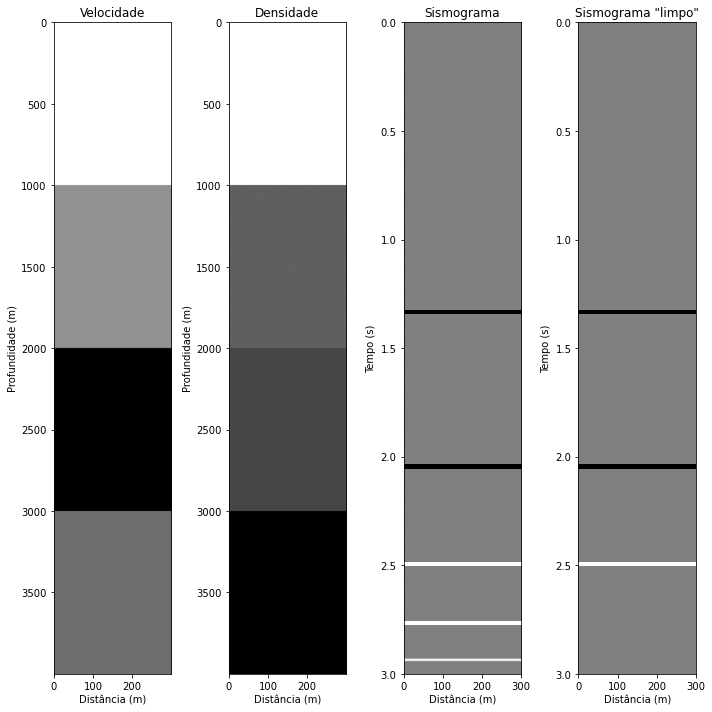

In [24]:
ModeloParalelas().plot()

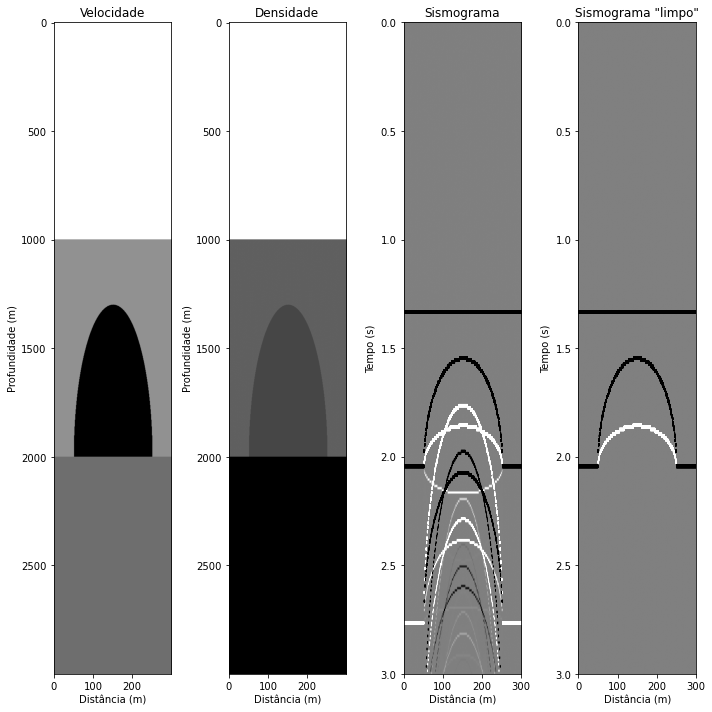

In [25]:
ModeloDomo().plot()

In [9]:
df = pd.DataFrame([{'a': 10, 'b': 1},
                   {'a': 20, 'b': 2},
                   {'a': 30, 'b': 3},
                   {'a': 40, 'b': 4}])
df['z'] = (df.index*1000).astype(float)
df.groupby('z').sum()

,a,b
z,,
0.0,10,1
1000.0,20,2
2000.0,30,3
3000.0,40,4


In [10]:
class Teste():
    @classmethod
    def testar(cls):
        method_list = [func for func in dir(cls) if callable(getattr(cls, func)) and not func.startswith('_') and not func == 'testar']
        for metodo in method_list:
            print(metodo)
            getattr(cls,metodo)()
    @staticmethod
    def criar_camada():
        Camada(1000,1500,1)
        print('\tCamada criada')
    @staticmethod
    def criar_modelo():
        lista = [Camada(1000,1500,1),
                 Camada(2000,2500,1.5)]
        Modelo(lista)
        print('\tModelo criado')
    @staticmethod
    def obter_reflexividade_transmissividade():
        lista = [Camada(1000,1500,1),
                 Camada(2000,2500,1)]
        m = Modelo(lista)
        print('\t', m.reflex[0])
    @staticmethod
    def obter_pulsos_limpo():
        lista = [Camada(1000,1000,1),
                 Camada(2000,2000,1),
                 Camada(3000,3000,1),
                 Camada(4000,4000,1)]
        m = Modelo(lista)
        print(m.obter_pulsos_limpo(t_max=10))
    @staticmethod
    def obter_pulsos():
        lista = [Camada(1000,1000,1),
                 Camada(2000,2000,1),
                 Camada(3000,3000,1),
                 Camada(4000,4000,1)]
        m = Modelo(lista)
        print(m.obter_pulsos(t_max=10))
Teste.testar()

criar_camada
	Camada criada
criar_modelo
	Modelo criado
obter_pulsos
             pulso
instante          
2.0       0.333333
4.0       0.177778
6.0       0.110053
8.0      -0.018947
10.0     -0.003436
obter_pulsos_limpo
             pulso
instante          
2.0       0.333333
4.0       0.177778
6.0       0.121905
obter_reflexividade_transmissividade
	 0.25
